# Notebook contains model to detect Collisions in NYC

This Notebook has various Forecast models using advanced Machine Learning techniques, to predict the possible collisions in the city. The model is finalized based on the least RMSE.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import pandas_profiling as pdp

import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/accidents_with_prediction.csv')

In [22]:
df['borough'].value_counts()

MANHATTAN        51346
BROOKLYN         32397
QUEENS           31040
BRONX            18085
STATEN ISLAND     4238
Name: borough, dtype: int64

In [ ]:
df1 = df[df['borough'] == 'MANHATTAN']
df2 = df[df['borough'] == 'BROOKLYN']
df3 = df[df['borough'] == 'QUEENS']
df4 = df[df['borough'] == 'BRONX']
df4 = df[df['borough'] == 'STATEN ISLAND']

def add_time_cols(df):
    ym, y, m, h = [], [], [], []

    for i in range(len(df1)):
        a, b, c, d= extract_ddy(df.timestamp[i])
        ym.append(a)
        y.append(b)
        m.append(c)
        h.append(d)

    df1['date'] = ym
    df1['year'] = y
    df1['month'] = m
    df1['hour'] = h

**Taking Manhattan data for for the Time-Series Model**

In [23]:
df1 = df[df['borough'] == 'BROOKLYN']

In [24]:
def extract_ddy(date):
    dd = date.split(' ')
    year_month = dd[0][:7]
    year_month_day = dd[0]
    year = int(year_month[:4])
    month = int(year_month[5:7])
    hour = int(dd[1][:2])
    return year_month_day, year, month, hour

In [26]:
df1 = df1.reset_index().iloc[:, 1:]

In [27]:
ym, y, m, h = [], [], [], []

for i in range(len(df1)):
    a, b, c, d= extract_ddy(df1.timestamp[i])
    ym.append(a)
    y.append(b)
    m.append(c)
    h.append(d)
    
df1['date'] = ym
df1['year'] = y
df1['month'] = m
df1['hour'] = h

In [28]:
df1.set_index(df1['date'],inplace=True)

In [29]:
df2 = pd.DataFrame(df1['date'].value_counts())

In [30]:
df2.columns = ['count']

In [31]:
df2.index = pd.to_datetime(df2.index)

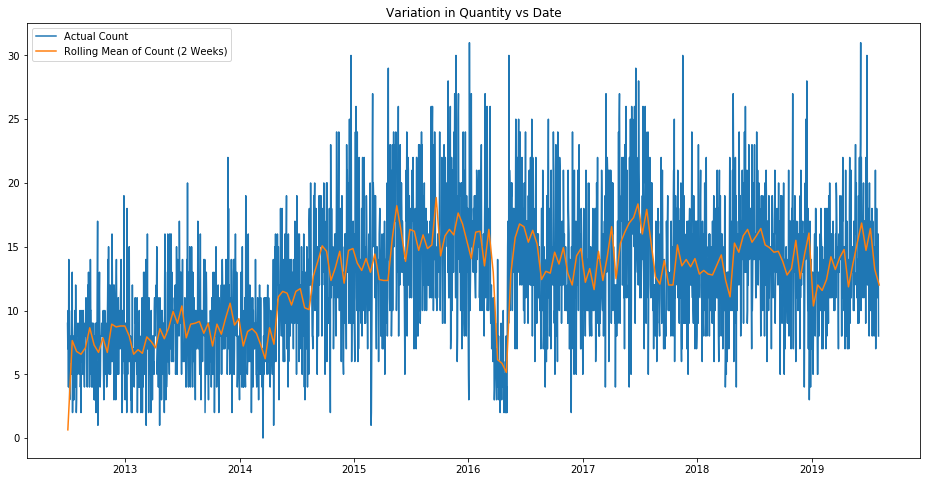

In [32]:
daily = df2['count'].resample('D').sum()
avg = df2['count'].resample('2W').sum()/14
avg.index = avg.index.shift(1, freq='D')

plt.figure(figsize=(16, 8))
plt.plot(daily, label='Actual Count')
plt.plot(avg, label='Rolling Mean of Count (2 Weeks)')
plt.title('Variation in Quantity vs Date')
plt.legend()
plt.show()

In [33]:
errors = pd.Series(avg - daily).fillna(method='ffill')
print('RMSE if Two-week Average is predicted: {}'.format((errors**2).mean()**.5))

RMSE if Two-week Average is predicted: 4.285846201316002


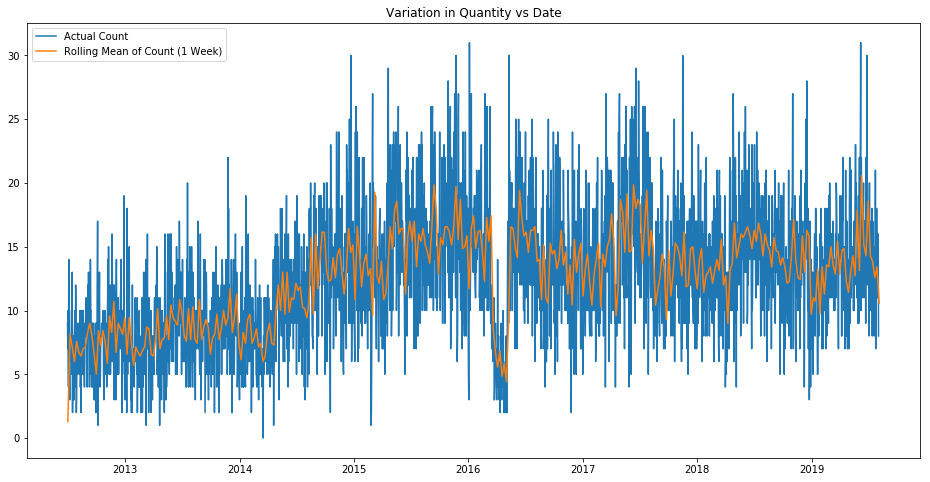

In [34]:
daily = df2['count'].resample('D').sum()
avg = df2['count'].resample('W').sum()/7
avg.index = avg.index.shift(1, freq='D')

plt.figure(figsize=(16, 8))
plt.plot(daily, label='Actual Count')
plt.plot(avg, label='Rolling Mean of Count (1 Week)')
plt.title('Variation in Quantity vs Date')
plt.legend()
plt.show()

In [35]:
errors = pd.Series(avg - daily).fillna(method='ffill')
print('RMSE if One-week Average is predicted: {}'.format((errors**2).mean()**.5))

RMSE if One-week Average is predicted: 4.317775826284318


### Trying the GRU Model to see if it can improve the Predictions

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GRU
from keras.layers import concatenate

**CNN 1D Model**

In [41]:
#Reshape the data
train = np.array(daily.values)
train = train.reshape(-1, 1)

#Convert to test_train_split
x_train = []
y_train = []
for i in range(60, len(train)):
    x_train.append(train[i-60:i])
    y_train.append(train[i])
    
#Split the dataset
x_train, y_train = np.array(x_train), np.array(y_train)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

regressor = Sequential()
regressor.add(Conv1D(filters = 45, kernel_size = 14, activation = "relu", \
                     input_shape = (x_train.shape[1], 1), padding = "same"))
regressor.add(MaxPooling1D(pool_size=2))
regressor.add(Conv1D(filters = 45, kernel_size = 14, activation = "relu",
                     padding = "same"))
regressor.add(MaxPooling1D(pool_size=2))
regressor.add(Flatten())
regressor.add(Dense(50, activation='relu'))
regressor.add(Dense(1))
regressor.compile(optimizer = "adam", loss = "mse")

history = regressor.fit(x_train, y_train, epochs=10, batch_size = 32, verbose=0)

#Apply predict on Test data and get the forecast
predict = regressor.predict(x_test)

W0813 05:17:44.694004 140400691152640 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



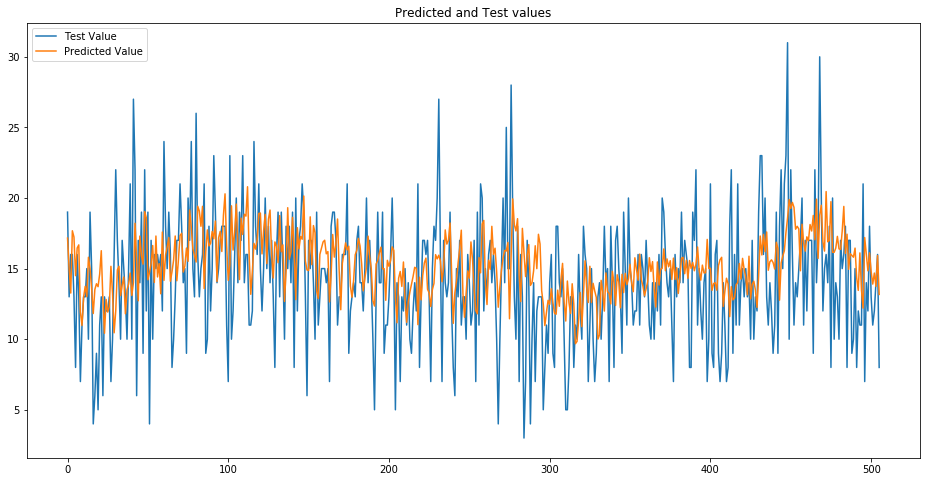

In [42]:
fig1 = plt.figure(figsize=(16,8))
plt.plot(y_test, label = "Test Value")
plt.plot(predict, label = "Predicted Value")
plt.title("Predicted and Test values")
plt.legend()
plt.show()
fig1;

In [43]:
print('RMSE = {}'.format((((predict - y_test)**2).mean())**0.5))

RMSE = 4.443759539491198


## We can try the CNN 1D Model for our Dataset. But for that we'll have to train five different Models for five of our Clusters/boroughs. That way we can have specific predictions for each region. 